In [1]:
%pylab inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import os
import warnings

mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.linewidth'] = 3

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True);

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
#Load Data!
data=fits.getdata('../data/ferengi_data.fits',1)

In [3]:
#Defining surface brightness bins
yedges=np.linspace(np.min(data['mu_max_i']),np.max(data['mu_max_i']),10)

In [4]:
#Pick out unique galaxies
galaxies = set(data['sdss_id'])

In [5]:
#simulated redshifts of ferengi data:
reds=[.3,.4,.5,.6,.7,.8,.9,1]
#Defining lists of p_features at high and low (z=0.3) redshifts at given SB and redshifts. 
scatter_dct={}
for z in reds:
    for edge in yedges:
        scatter_dct[z,edge,'hi']=[]
        scatter_dct[z,edge,'lo']=[]
        scatter_dct[z,edge,'subj_id']=[]

In [6]:
#In each SB range and simulated redshift, make a list of p_features at that redshift and p_features at z=0.3   
for i,g in enumerate(galaxies):
    this_gal=(data['sdss_id']==g)
    evos = set(data[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(data[this_gal]['sim_evolution']==e)
        if len(set(data[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(data[this_gal][this_evo]['sim_redshift']==.3)
            p_features_at_3 = data[this_gal][this_evo][p_at_3]['p_features'][0]#value of p_bar at redshift 0.3
            for row in data[this_gal][this_evo]:
                for y in range(0,len(yedges)-1):
                    for j,hi_z in enumerate(reds):
                        if round(row['sim_redshift'],2)==hi_z and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1]: #now look at high redshift data
                            scatter_dct[hi_z,yedges[y],'hi'].append(row['p_features']) # slap p_features in high list 
                            scatter_dct[hi_z,yedges[y],'lo'].append(p_features_at_3) # put z=0.3 value in low list 
                            scatter_dct[hi_z,yedges[y],'subj_id'].append(row['subject_id'])
                            
         

In [7]:
'''
Approach: fit data with low-order polynomial, 
then evaluate polynomial near bin points. 

Fit function must pass between (0,0) and (1,1); 
uses method of Lagrange multipliers detailed
here: http://stackoverflow.com/questions/15191088/how-to-do-a-polynomial-fit-with-fixed-points
'''

def polyfit_with_fixed_points(n, xs, ys, xf, yf) :
    mat = np.empty((n + 1 + len(xf),) * 2)
    vec = np.empty((n + 1 + len(xf),))
    x_n = xs**np.arange(2 * n + 1)[:, None]
    yx_n = np.sum(x_n[:n + 1] * ys, axis=1)
    x_n = np.sum(x_n, axis=1)
    idx = np.arange(n + 1) + np.arange(n + 1)[:, None]
    mat[:n + 1, :n + 1] = np.take(x_n, idx)
    xf_n = xf**np.arange(n + 1)[:, None]
    mat[:n + 1, n + 1:] = xf_n / 2
    mat[n + 1:, :n + 1] = xf_n.T
    mat[n + 1:, n + 1:] = 0
    vec[:n + 1] = yx_n
    vec[n + 1:] = yf
    params = np.linalg.solve(mat, vec)
    
    return params[:n + 1]

def calculate_hbins(vbins,deg):
    
    eps = 1e-3
    xf = (0+eps,1) # offset by small amount so matrix is non-singular
    yf = (0,1)
    p = polyfit_with_fixed_points(deg,xs,ys,xf,yf)
    poly = np.polynomial.Polynomial(p)
    
    return poly

In [8]:
def plot_hbins(poly):
#    fig,ax = plt.subplots()
    ax.scatter(xs,ys,c='k')
    x_new = np.linspace(0,1,1000)
    ax.plot(x_new,poly(x_new),color='k',ls='--',ms=5,alpha=.8)
    astart,vstart = 0.,0.
    colors=['#CD00CD','#B0171F','#2E8B57','#104E8B']
    for v,vb in enumerate(vbins):
        hb = poly(vb)
        aend = 1. if vb==1. else hb
        ax.axhline(astart,alpha=1,lw=1,color='k')
#        ax.text(1.1,np.mean((astart,aend)),'Bin %.1f to %.1f' % (vstart,vb) )
        vstart = vb
        astart = hb
    ax.set_xlim(0,1);
    ax.set_ylim(0,1);
    
    return None

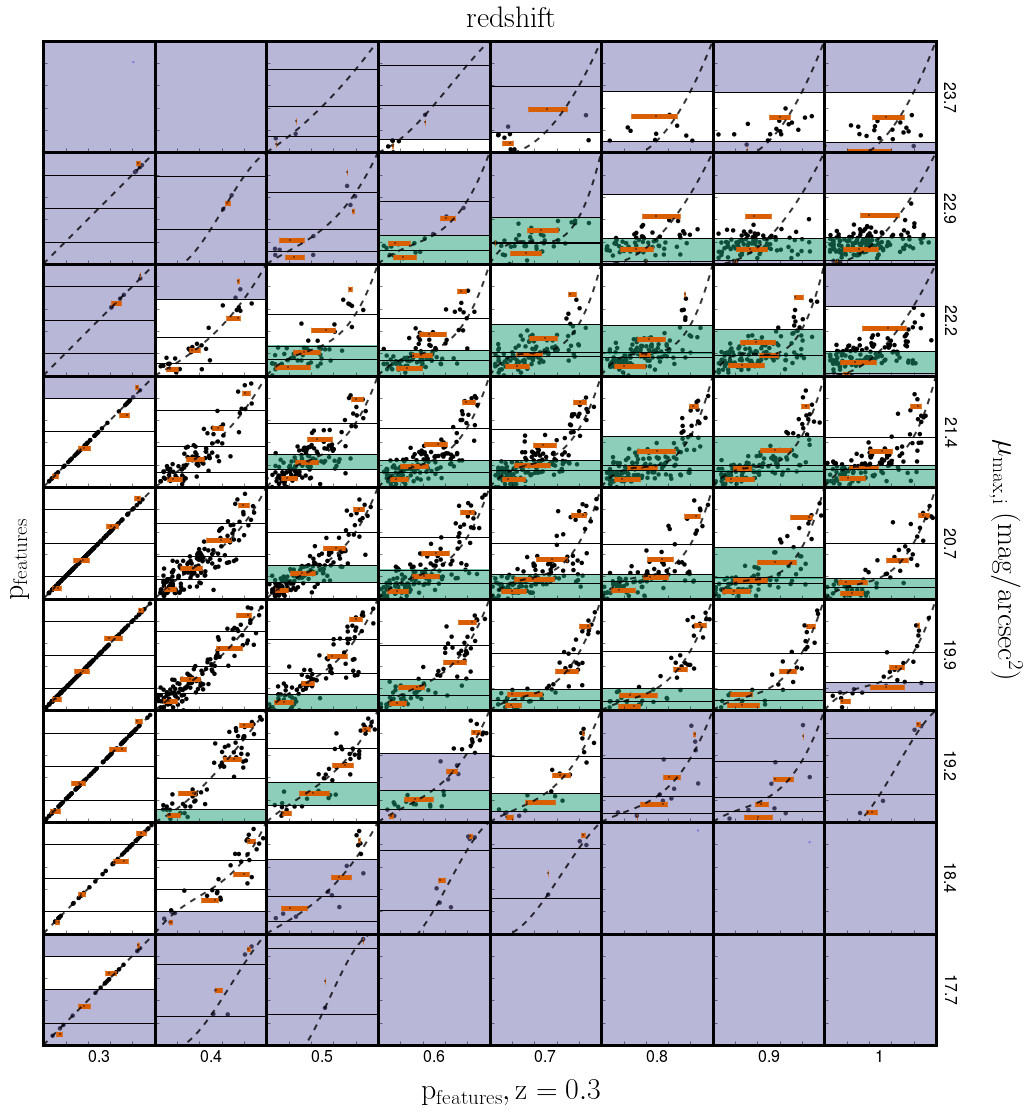

In [9]:
#Plot p_features at a given redshift vs p_features at z=0.3 at each redshift, binned by surface brightness
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
#redshift bins
vbins = (0.2,0.5,0.8,1.0)


gs=gridspec.GridSpec(9,10)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=[8,7,6,5,4,3,2,1,0]
y_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,1))
y_label=y_label[::-1]
for j,y in enumerate(yedge_int):
    for i,z in enumerate(reds):
        ax=plt.subplot(gs[j,i])
        xs=scatter_dct[z,yedges[y],'lo']
        ys=scatter_dct[z,yedges[y],'hi']
        p_range_uncorrectable_dct[z,yedges[y]]=[]
        p_range_correctable_dct[z,yedges[y]]=[]
        interval_dct[z,yedges[y]]=[]
        p_uncorrectable_list=[]
        p_correctable_list=[]
        
        if len(xs)>1:
            poly = calculate_hbins(vbins,3)
            if poly(vbins)[1] < poly(vbins)[0]:#bump in curve, bin edges out of order. No! 
                poly = calculate_hbins(vbins,2)#redo with 2nd degree polynomial 
                plot_hbins(poly)
            else: #things are fine, go ahead and plot
                plot_hbins(poly) 
        else: #if there are fewer than 2 points, can't fit polynomial. 
            plt.scatter(xs,ys,marker='o',s=5,c='blue',edgecolor='None',alpha=.5)
            plt.axhspan(0,1,alpha=0.5,color='#7570b3')
            plt.xlim(0,1)
            plt.ylim(0,1)
        this_dct={}  #stores p_features at z=0.3 value for each bin (xs); use to compute spread in each bin
                    #stored like: this_dct[lower_bin_edge,higher_bin_edge] = [distribution of xs in bin]

        bins_list=list(poly(vbins)) if len(xs)>1 else [0] #find appropriate bin edges
        bins_list.sort()
        bins_list.insert(0,0) #insert 0 for bottom bin edge
        #bins_list[0]=0 #bring lowest bin to zero
        for b in range(0,len(bins_list)-1):
            bin_bottom = round(bins_list[b],3)
            bin_top = round(bins_list[b+1],3)
            this_dct[bin_bottom,bin_top]=[]
            for l,val in enumerate(ys): #check p_features at z values
                if val >= bin_bottom and val < bin_top: # if it falls inside bin in question:
                    this_dct[bin_bottom,bin_top].append(xs[l]) #then put corresponding p_features,z=0.3 value in list
        
        #Now compute the mean and spread of p_features,z=0.3 for each bin
        p_features_means=[]
        x_error_lo=[]
        x_error_hi=[]
        bin_centers=[]

        for b in range(0,len(bins_list)-1):
            bin_bottom = round(bins_list[b],3)
            bin_top = round(bins_list[b+1],3)
            p_features_means.append(np.median(this_dct[bin_bottom,bin_top]))
            try:
                x_error_lo.append(p_features_means[b] - np.percentile(this_dct[bin_bottom,bin_top],25))
            except IndexError,ValueError:
                x_error_lo.append(0)
            try:
                x_error_hi.append(np.percentile(this_dct[bin_bottom,bin_top],75) - p_features_means[b])
            except IndexError,ValueError:
                x_error_hi.append(0)
            bin_centers.append((bin_top-bin_bottom)/2.+bin_bottom)
            try:
                interval_dct[z,yedges[y]].append({'bin_bottom':bin_bottom,'bin_top':bin_top,'low_limit':np.percentile(this_dct[bin_bottom,bin_top],25),'hi_limit':np.percentile(this_dct[bin_bottom,bin_top],75)})
            except IndexError,ValueError:
                pass
        plt.errorbar(p_features_means,bin_centers,xerr=[x_error_lo,x_error_hi],fmt='o',c='#d95f02',markersize=1,elinewidth=5)

        
       #now: check width of spread
        for b in range(0,len(bins_list)-1):
            bin_bottom = round(bins_list[b],3)
            bin_top = round(bins_list[b+1],3)
            bin_width = bin_top - bin_bottom
            spread = x_error_lo[b]+x_error_hi[b]
            points_in_bin=len(this_dct[bin_bottom,bin_top])
            try:
                if spread > bin_width and points_in_bin>=5: #uncorrectable:
                    plt.axhspan(bin_bottom,bin_top,alpha=0.5,color='#1b9e77')
                    p_uncorrectable_list.append(bin_bottom)
                    p_uncorrectable_list.append(bin_top)
                if spread < bin_width and points_in_bin >=5: #correctable! fo sho!
            #        plt.axhspan(bin_bottom,bin_top,alpha=0.2,color='m')
                    p_correctable_list.append(bin_bottom)
                    p_correctable_list.append(bin_top)
                if points_in_bin<5: #nei?
                    plt.axhspan(bin_bottom,bin_top,alpha=0.5,color='#7570b3')
            except ValueError:
                pass
        if len(p_uncorrectable_list)>0: #if square has any uncorrectable bins, store lowest and highest bin edge values 
            p_range_uncorrectable_dct[z,yedges[y]].append(np.min(p_uncorrectable_list))
            p_range_uncorrectable_dct[z,yedges[y]].append(np.max(p_uncorrectable_list))
        else: 
            p_range_uncorrectable_dct[z,yedges[y]].append(0)
            p_range_uncorrectable_dct[z,yedges[y]].append(0)
        if len(p_correctable_list)>0:
            p_range_correctable_dct[z,yedges[y]].append(np.min(p_correctable_list))
            p_range_correctable_dct[z,yedges[y]].append(np.max(p_correctable_list))
        else:
            p_range_correctable_dct[z,yedges[y]].append(0)
            p_range_correctable_dct[z,yedges[y]].append(0)

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')

        if j==8:
            plt.xlabel('%s'%reds[i],fontsize=16)
        if i==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%y_label[j],fontsize=16,rotation=270,labelpad=20)

f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3}$',fontsize=30,ha='center');

#plt.savefig('images/p_vs_p_SB_redshift_Kyle_bins.pdf')

In [10]:
#correctable range: white region 
#uncorrectable range: blue region
#NEI region: pink (or not on plot) 

In [11]:
#get list of debiasable ferengi galaxies 
unique_galaxies = set(data['sdss_id'])
z0ind = np.zeros(len(data),dtype=bool)
for ug in unique_galaxies:
    ind = (data['sdss_id'] == ug)
    if data[ind]['sim_redshift'].min() < 0.301:
        z0ind[ind] = True
        
data_z0 = data[z0ind]
category_list_ferengi=[]
for row in data_z0:
    if row['mu_max_i'] > yedges[0] and row['mu_max_i'] <= yedges[len(yedges)-1] and  row['sim_redshift'] > reds[0]-.05 and row['sim_redshift'] <= reds[len(reds)-1] + .05: # if within ferengi space, check where it is. else, consider NEI or uncorrectable.
        for y in range(0,len(yedges)-1):
            if row['mu_max_i'] > yedges[y] and row['mu_max_i'] <= yedges[y+1]:  
                for i,z in enumerate(reds): 
                    if row['sim_redshift'] > reds[i]-.05 and row['sim_redshift'] <= reds[i] + .05: # pick out where it is in SB/z and check color
                        if row['p_features'] > p_range_correctable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_correctable_dct[z,yedges[y]][1]:# if it's in correctable range::
                            category_list_ferengi.append({'objid':row['subject_id'],'Correctable_Category':'correctable'})
                        elif row['p_features'] > p_range_uncorrectable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_uncorrectable_dct[z,yedges[y]][1]:# if it's in uncorrectable range::
                            category_list_ferengi.append({'objid':row['subject_id'],'Correctable_Category':'uncorrectable'})
                        else: #not in correctable or uncorrectable range, so nei
                            category_list_ferengi.append({'objid':row['subject_id'],'Correctable_Category':'nei'})
    else: #galaxies outside ferengi SB and z limits - still need to have meaasureable z and SB to possibly correct. 
        if row['sim_redshift'] > 0 and row['sim_redshift'] < 9 and row['mu_max_i'] >0: #these have measurements for z and SB, put in NEI
            category_list_ferengi.append({'objid':row['subject_id'],'Correctable_Category':'nei'})
        else: #these have nan or infinite values of z or mu, put in need_redshift_list
            category_list_ferengi.append({'objid':row['subject_id'],'Correctable_Category':'nei_needs_redshift'})

In [12]:
#create fits file of galaxies with Correctable_Category Label for FERENGI
c0 = Column([x['objid'] for x in category_list_ferengi], name='objid') 
c01 = Column([x['Correctable_Category'] for x in category_list_ferengi], name='Correctable_Category')
category_table_ferengi = Table()  
category_table_ferengi.add_columns([c0,c01])

from astropy.table import hstack
writetable = hstack([Table(data),category_table_ferengi])

fname = '../data/ferengi_debiasable_data.fits'
if os.path.exists(fname):
    os.remove(fname)
writetable.write(fname,format='fits')

In [13]:
hubble_data=fits.getdata('../data/Hubble_t01_data.fits',1)

In [14]:
#determine which parts of hubble sample are correctable (white), uncorrectable (green), or nei (purple) 

category_list=[]
for row in hubble_data:
    if row['MU_HI'] > yedges[0] and row['MU_HI'] <= yedges[len(yedges)-1] and  row['Z'] > reds[0] and row['Z'] <= reds[len(reds)-1] + .05: # if within ferengi space, check where it is. else, consider NEI or uncorrectable.
        for y in range(0,len(yedges)-1):
            if row['MU_HI'] > yedges[y] and row['MU_HI'] <= yedges[y+1]:  
                for i,z in enumerate(reds): 
                    if row['Z'] > reds[i]-.05 and row['Z'] <= reds[i] + .05: # pick out where it is in SB/z and check color
                        if row['p_features'] > p_range_correctable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_correctable_dct[z,yedges[y]][1]:# if it's in correctable range::
                            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'correctable','Imaging':row['Imaging']})
                        elif row['p_features'] > p_range_uncorrectable_dct[z,yedges[y]][0] and row['p_features'] <= p_range_uncorrectable_dct[z,yedges[y]][1]:# if it's in uncorrectable range::
                            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'uncorrectable','Imaging':row['Imaging']})
                        else: #not in correctable or uncorrectable range, so nei
                            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'nei','Imaging':row['Imaging']})
    else: #galaxies outside ferengi SB and z limits - still need to have meaasureable z and SB to possibly correct. 
        if row['Z'] >=.3 and row['Z'] < 9 and row['MU_HI'] >0: #these have measurements for z and SB, put in NEI
            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'nei','Imaging':row['Imaging']})
        elif row['Z'] > 0 and row['Z'] < .3: #don't need to be corrected, z < z0
            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'z_lt_3','Imaging':row['Imaging']})
        else: #these have nan or infinite values of z or mu, put in need_redshift_list
            category_list.append({'objid':row['OBJNO'],'Correctable_Category':'nei_needs_redshift','Imaging':row['Imaging']})

In [15]:
low_hi_limit_list=[]
for row in hubble_data:
    if row['MU_HI'] > yedges[0] and row['MU_HI'] <= yedges[len(yedges)-1] and  row['Z'] > reds[0]-.05 and row['Z'] <= reds[len(reds)-1] + .05: 
        for y in range(0,len(yedges)-1):
            if row['MU_HI'] > yedges[y] and row['MU_HI'] <= yedges[y+1]:  
                for i,z in enumerate(reds): 
                    if row['Z'] > reds[i]-.05 and row['Z'] <= reds[i] + .05: #now we have mu,z info:
                        for bin_range in interval_dct[z,yedges[y]]:
                            if row['p_features'] >= bin_range['bin_bottom'] and row['p_features'] < bin_range['bin_top']:
                                low_hi_limit_list.append({'objid':row['OBJNO'],'low_limit':bin_range['low_limit'],'hi_limit':bin_range['hi_limit']})
                        


In [16]:
imaging_list=set(hubble_data['Imaging'])
total_correctable=0
total_uncorrectable=0
total_z_lt_3=0
total_nei=0
total_nr=0
for survey in imaging_list:
    c=0
    u=0
    z_lt_3=0
    nei=0
    nr=0
    for row in category_list:
        if row['Correctable_Category']=='correctable' and row['Imaging']==survey:
            c+=1
        if row['Correctable_Category']=='uncorrectable' and row['Imaging']==survey:
            u+=1
        if row['Correctable_Category']=='z_lt_3' and row['Imaging']==survey:
            z_lt_3+=1
        if row['Correctable_Category']=='nei' and row['Imaging']==survey:
            nei+=1
        if row['Correctable_Category']=='nei_needs_redshift' and row['Imaging']==survey:
            nr+=1
    total_correctable+=c
    total_uncorrectable+=u
    total_z_lt_3+=z_lt_3
    total_nei+=nei
    total_nr+=nr
    print 'the number of correctable galaxies in %s is %i' %(survey,c)
    print 'the number of uncorrectable galaxies in %s is %i' %(survey,u)
    print 'the number of galaxies with z < 0.3 in %s is %i' %(survey,z_lt_3)
    print 'the number of NEI galaxies in %s is (due to not enough Ferengi galaxies in bin) is %i' %(survey,nei)
    print 'the number of NEI galaxies in %s is (due to needing redshift measurements) is %i' %(survey,nr)
print 'total correctable: %i' %total_correctable
print 'total uncorrectable: %i' %total_uncorrectable
print 'total z less than .3: %i' %total_z_lt_3
print 'total nei: %i' %total_nei
print 'total nr: %i' %total_nr
print 'total: %i' %len(category_list)

the number of correctable galaxies in GEMS is 2748
the number of uncorrectable galaxies in GEMS is 1832
the number of galaxies with z < 0.3 in GEMS is 1190
the number of NEI galaxies in GEMS is (due to not enough Ferengi galaxies in bin) is 1886
the number of NEI galaxies in GEMS is (due to needing redshift measurements) is 1648
the number of correctable galaxies in GOODS-S is 1022
the number of uncorrectable galaxies in GOODS-S is 980
the number of galaxies with z < 0.3 in GOODS-S is 247
the number of NEI galaxies in GOODS-S is (due to not enough Ferengi galaxies in bin) is 2023
the number of NEI galaxies in GOODS-S is (due to needing redshift measurements) is 641
the number of correctable galaxies in COSMOS is 20669
the number of uncorrectable galaxies in COSMOS is 19626
the number of galaxies with z < 0.3 in COSMOS is 11693
the number of NEI galaxies in COSMOS is (due to not enough Ferengi galaxies in bin) is 33727
the number of NEI galaxies in COSMOS is (due to needing redshift mea

In [17]:
#create fits file of galaxies with Correctable_Category Label 
c0 = Column([x['objid'] for x in category_list], name='objid') 
c01 = Column([x['Correctable_Category'] for x in category_list], name='Correctable_Category')
category_table = Table()  
category_table.add_columns([c0,c01])

fname = 'category_table.fits'
if os.path.exists(fname):
    os.remove(fname)
category_table.write(fname,format='fits')

In [18]:
#create fits file of lower and upper limits for p_features
c2 = Column([x['objid'] for x in low_hi_limit_list], name='objid') 
c3 = Column([x['low_limit'] for x in low_hi_limit_list], name='low_limit') 
c4 = Column([x['hi_limit'] for x in low_hi_limit_list], name='hi_limit') 
limit_table = Table()  
limit_table.add_columns([c2,c3,c4])

fname = 'limits_table.fits'
if os.path.exists(fname):
    os.remove(fname)
limit_table.write(fname,format='fits')